# Qiskit 7 - Shores algorithm

#### Table of content

1. Introduction
2. Choose N
3. Get a
4. Phase estimation
5. QFT - Quantum Fourier Transform
6. Unitary Operator
7. Simulation 
8. IBMQ 

In [109]:
import numpy as np
from math import gcd

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute, IBMQ
from qiskit.tools.visualization import circuit_drawer, plot_histogram

## 1 - Introduction

#### Problem

The problem of factoring integers can be expressed in such way, that based on some integer $N$, one want to find the integers $N_1$ and $N_2$, such that: $N_1N_2 = N$, meanwhile: $1 < N_1, N_2 < N$ 

Shores algorithm approaches this problem by reducing it into finding the period of a certain function. 

#### Algorithm

***step 1*** Pick an integer $N$ and use a classical algorithm to determine if it is prime or a power of prime. If so, exit.

***step 2*** Randomly choose an integer $a$ such that $1 < a < N$. Perform Euclid's algorithm to determine if the $GCD(a, N)$ is 1. If not, exit.

***step 3*** Use the quantum circuit represented by the unitary operator ${U}_{fa, N}$ to find a period $r$.

***step 4*** If $a$ is odd, or if $a^{\frac{r}{2}} \equiv -1$ Mod $N$, then return to step 2 and choose another $a$.

***step 5*** Use Euclid's algorithm to calculate $GCD((a^{\frac{r}{2}} + 1), N)$ and $GCD((a^{\frac{r}{2}} - 1), N)$. Return at least one of the nontrivial solutions.

## 2 - Choose N

So we will work with a non-prime, non power of prime positive integer such that it is manageable on a handful couple of qubits. Allow me to put together the following list of candidates:

* List of possible integers = [4, 6, 8, 10, 12, 14, 15, 18]

In [86]:
N = 4
N_bit = format(N, 'b')
print('N =', N)
print('N bit =', N_bit)

N = 4
N bit = 100


## 3 - Get a

If $GCD(a,N) = 1$ a is a co-prime of N and that is what we can use in following steps. Hence we ought to pull random $a$ and check its common factors against N, if it is a 1 we keep it. 

In [87]:
for i in range(N):
    a = np.random.randint(2, N)
    GCD = gcd(a, N)
    if GCD is 1:
        print('gcd is 1 for a:', a)
        break

gcd is 1 for a: 3


## 4 - Phase estimation


#### The modular function
First up is to find the powers of $a$ $Mod$ $N$, that is:
 
$$a^0 Mod N, a^1 Mod N, a^3 Mod N, ...$$

In other words we are to find the values $x$ of the function:

$$f_{a,N}(x) = a^x Mod N$$

However we are rather interested in the period $r$ of this function such that:

$$f_{a,N}(r) = a^r Mod N$$

It is known from a number theory theorem that for any co-prime $a \leq N$, the function $f_{a,N}(r)$ will output a 1 for some $r \leq N$. After it hits 1, the sequence of numbers will simply repeat itself. *(isn't this a mechanism we could use for reformulated optimization problems?).*


#### State dynamics
Next step is to implement the function $f_{a,N}$ on a quantum circuit, in order to do that we are to proceed according to the following procedure:

**1:** Define 2 quantunRegisters. The first one $|x\rangle_m$ and the second one $|y\rangle_n$. Where $m$ = the binary length needed to hold N, and where $n$ = the binary length needed to hold the periodic base of N.

$$|\varphi_0 \rangle = |x_m, y_n \rangle$$

**2:** Place the $|x \rangle_m$ qubits in an equally weighted superposition:

$$|\varphi_1 \rangle = \frac{\sum_{x\epsilon[0, 1]^m}|x, y_n\rangle}{\sqrt{2^m}}$$

**3:** Evaluate the function $f_{a,N}(x)$ for all the superpositioned possibilities:

$$|\varphi_2 \rangle = \frac{\sum_{x\epsilon[0, 1]^m}|x, f_{a,N}(x)\rangle}{\sqrt{2^m}} = \frac{\sum_{x\epsilon[0, 1]^m}|x, a^x Mod N\rangle}{\sqrt{2^m}}$$

**4:** By measuring the bottom qubits $|y\rangle_n$ we obtain an estimate $a^{\overline{x}}Mod N$ for some $\overline{x}$. By the periodicity of $f_{a,N}$ we also have that:

$$a^{\overline{x}} \equiv a^{\overline{x}+r}ModN$$
and,
$$a^{\overline{x}} \equiv a^{\overline{x}+2r}ModN$$
such that for any $s$ $\epsilon$ $\mathbb Z$ we have:
$$a^{\overline{x}} \equiv a^{\overline{x}+sr}ModN$$

Furthermore we have that out of the $2^m$ superpositions in $|x\rangle$ in state $|\varphi_2\rangle$, there are $\frac{2^m}{r}$ of them that has the solution $\overline{x}$. This finally gives us:

$$|\varphi_3 = \frac{\sum_{a \equiv a^{\overline{x}}ModN}|x,a^{\overline{x}}\rangle}{\frac{2^m}{r}} = \frac{\sum^{\frac{2^m}{r-1}}_{j=0}|t_0 + jr, a^{\overline{x}ModN}\rangle}{\frac{2^m}{r}}$$

Where $t_0$ is the first time the measured the value of $a^{t_0} \equiv a^{\overline{x}}ModN$

To boil this down, we want to estimate $\overline{x}$ since that gives us a value to plug into the function $f_{a,N}$ which gives us the period base we are looking for. Hence this stage starts with preparing the states and end with taking the measurements of $|y\rangle$ such that a satisfying value can be detected. *(Do we use that value and re instantiate the x qubits? Or is the superpoitioned x state to be 'automatically manipulated' by our measurements of y such that it simply takes on our preferred value?)*


#### Quantum circuit
So how do we construct the black box unitary? Allow us to establish a relationship between the period of the function $f_{a,N}$ and the phase value of the eigenvalue. 
this way solving the phase helps us find the period. 

Phase estimation can described such that if we know $U$ and $|\psi\rangle$, we can estimate $\phi$:

$$U|\psi\rangle = e^{2\pi i\phi}|\psi\rangle$$

Proceeding with the following specifications:
$$N = 4 = 100_{bin}$$
$$a = 3$$
$$n = 3$$
$$r = 2 = 01_{bin}$$
$$freq = (1, 3)$$
$$m = 6$$

### Define registers

In [95]:
x = QuantumRegister(6, 'x')
y = QuantumRegister(3, 'y')
c1 = ClassicalRegister(3, 'c1')
c2 = ClassicalRegister(6, 'c2')

### QFT - Quantum Fourier Transform

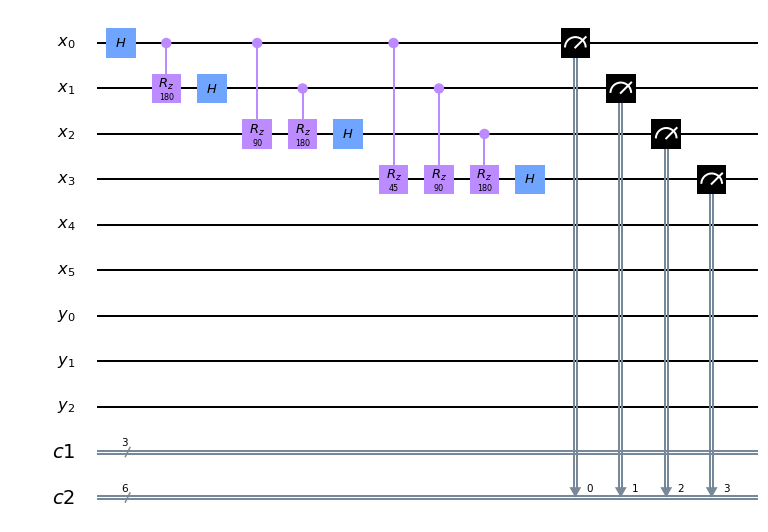

In [121]:
q1 = QuantumCircuit(x, y, c1, c2)
q1.barrier()
q1.h(x[0])
q1.crz(180, x[0], x[1])
q1.h(x[1])
q1.crz(90, x[0], x[2])
q1.crz(180, x[1], x[2])
q1.h(x[2])
q1.barrier()
q1.crz(45, x[0], x[3])
q1.crz(90, x[1], x[3])
q1.crz(180, x[2], x[3])
q1.h(x[3])
q1.barrier()
q1.measure([x[0], x[1], x[2], x[3]], [c2[0], c2[1], c2[2], c2[3]])
circuit_drawer(q1, output='mpl', plot_barriers=False)

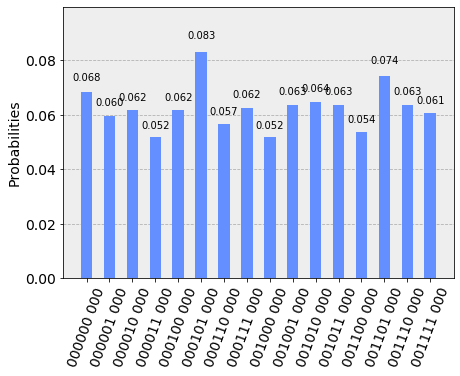

In [125]:
sim = Aer.get_backend('qasm_simulator')
count = execute(q1, sim).result().get_counts()
plot_histogram(count)

#### To be continued...